In [636]:
import pandas as pd
import time
import spacy
import numpy as np
from datetime import datetime, timezone
import pytz  
import tzlocal
from dateutil import tz
import re
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from collections import defaultdict
from backports.zoneinfo import ZoneInfo
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from os import path

# stopwords, tokenizer, stemmer
import nltk  
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import RSLPStemmer
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# data visualization
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.express as px
import seaborn as sns
from matplotlib import rcParams
import matplotlib.ticker as ticker

In [637]:
df = pd.read_csv("dados_anotados.csv", encoding='UTF-8')

In [638]:
df.shape

(2000, 8)

In [639]:
df.head()

,Unnamed: 0,Tweet_ID,Tweet_Text,Created_at,Tweet_Geo,User_Name,User_Location,Sentiment
0,255201,1.556983e+18,@medoedeliriobr Vai rolar curadoria disso aí? ...,2022-08-09 12:38:33+00:00,NaN,Fernando,Maringá/PR,negativo
1,1038314,1.551390e+18,@MarquesToalinha @alvesmimar3 @derontoldos @Ma...,2022-07-25 02:14:53+00:00,NaN,ZiláPatriota🇧🇷,"Minas Gerais, Brasil",neutro
2,551557,1.554856e+18,ELEIÇÕES 2022 - Enquetes PROIBIDAS pelo TSE e ...,2022-08-03 15:43:43+00:00,NaN,marize reis,NaN,neutro
3,162714,1.557467e+18,@MarquinDJ5 @MuskDontBanMe @borine_savio @mona...,2022-08-10 20:39:08+00:00,NaN,Iandra Karisia,NaN,positivo
4,952391,1.552006e+18,Vc sabia? Bolsonaro disse ao STF que o seu gov...,2022-07-26 19:00:16+00:00,NaN,oranosloB,Cloud,neutro


In [640]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     2000 non-null   int64  
 1   Tweet_ID       2000 non-null   float64
 2   Tweet_Text     2000 non-null   object 
 3   Created_at     2000 non-null   object 
 4   Tweet_Geo      50 non-null     object 
 5   User_Name      2000 non-null   object 
 6   User_Location  994 non-null    object 
 7   Sentiment      2000 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 125.1+ KB


In [641]:
nlp = spacy.load('pt_core_news_lg')
def preprocess(df):
    stop_words = stopwords.words('portuguese')
    new_stopwords= ['q','pro', 'pra','tar','ter', 'pq', 'aí', 'então', 'porque', 'ir', 'vc', 'tá']
    stop_words.extend(new_stopwords)
    st = RSLPStemmer()
    
    df['Tweet_Text'].dropna(inplace=True)

    #Remove nome de usuários (está diminuindo a precisão)
    df['Tweet_Text'] = [re.sub('@[^\s]+','', entry) for entry in df['Tweet_Text']]

    # Remove @RT de retweets
    df['Tweet_Text'] = [re.sub(r'^RT[\s]+', '', entry) for entry in df['Tweet_Text']]

    # Remove hiperlinks
    df['Tweet_Text'] = [re.sub(r'https?:\/\/.*[\r\n]*', '', entry) for entry in df['Tweet_Text']]
    
    #Lemetizacao
    df["Tweet_Text"] = df['Tweet_Text'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x)]))
    
    #stemming
    #df["Tweet_Text"] = df['Tweet_Text'].apply(lambda x: " ".join([st.stem(word) for word in df['Tweet_Text']]))
    
    # Padroniza todo o texto em caixa baixa (letras minúsculas)
    df['Tweet_Text'] = [entry.lower() for entry in df['Tweet_Text']]
    
    #Remover stopwords
    df['Tweet_Text'] = df['Tweet_Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words) and word.isalpha()]))
    
    
    #Tokenização: Cada tweet é dividido em um array de palavras
    df['Tweet_Text']= [word_tokenize(entry) for entry in df['Tweet_Text']]
    
    #transformar tweet text em array de strings
    df['Text_Final']= [str(item) for item in df['Tweet_Text']]

    #Remove Z format
    date_column = []
    for datez in df['Created_at']:
        datez= (datez.split("+", 1))[0]
        date_column.append(datez)
    df['Created_at'] = date_column
    
    #convert timezone

    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz("America/Sao_Paulo")
    local = []
    for date in df['Created_at']:
        date = datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
        date = date.replace(tzinfo=from_zone)
        # Convert time zone
        date = date.astimezone(to_zone)
        local.append(date)

    df['Created_at'] = local
    
    #separate column date to date and time
    df['Date_Created'] = pd.to_datetime(df['Created_at']).dt.date
    df['Time_Created'] = pd.to_datetime(df['Created_at']).dt.time
    
 

In [642]:
preprocess(df)

In [643]:
df.head()

,Unnamed: 0,Tweet_ID,Tweet_Text,Created_at,Tweet_Geo,User_Name,User_Location,Sentiment,Text_Final,Date_Created,Time_Created
0,255201,1.556983e+18,"[rolar, curadoria, interessado, ver, três, hor...",2022-08-09 09:38:33-03:00,NaN,Fernando,Maringá/PR,negativo,"['rolar', 'curadoria', 'interessado', 'ver', '...",2022-08-09,09:38:33
1,1038314,1.551390e+18,"[votar, nulo, deixar, votar]",2022-07-24 23:14:53-03:00,NaN,ZiláPatriota🇧🇷,"Minas Gerais, Brasil",neutro,"['votar', 'nulo', 'deixar', 'votar']",2022-07-24,23:14:53
2,551557,1.554856e+18,"[eleições, enquetes, proibidas, tse, bolsonaro...",2022-08-03 12:43:43-03:00,NaN,marize reis,NaN,neutro,"['eleições', 'enquetes', 'proibidas', 'tse', '...",2022-08-03,12:43:43
3,162714,1.557467e+18,"[putz, ainda, bolsonaro, fazer, várias, lei, d...",2022-08-10 17:39:08-03:00,NaN,Iandra Karisia,NaN,positivo,"['putz', 'ainda', 'bolsonaro', 'fazer', 'vária...",2022-08-10,17:39:08
4,952391,1.552006e+18,"[saber, bolsonaro, dizer, stf, governo, omitir...",2022-07-26 16:00:16-03:00,NaN,oranosloB,Cloud,neutro,"['saber', 'bolsonaro', 'dizer', 'stf', 'govern...",2022-07-26,16:00:16


In [694]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['Text_Final'],df['Sentiment'],test_size=0.3)

Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

#Padrões TF-IDF
Tfidf_vect = TfidfVectorizer(max_features=10000)
Tfidf_vect.fit(df['Text_Final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

#print(Tfidf_vect.vocabulary_)

#print(Train_X_Tfidf)

In [696]:
# ajustar o conjunto de dados de treinamento no classificador NB
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# prever os rótulos no conjunto de dados de validação
predictions_NB = Naive.predict(Test_X_Tfidf)

#imprimir na tela a acurácia, f-measure, precisão e recall
print("Naive Bayes Accuracy: ",accuracy_score(predictions_NB, Test_Y)*100)
print("Naive Bayes F-Measure: ",f1_score(predictions_NB, Test_Y, average="macro")*100)
print("Naive Bayes Precision: ",precision_score(predictions_NB, Test_Y, average="macro")*100)
print("Naive Bayes Recall: ",recall_score(predictions_NB, Test_Y, average="macro")*100)

Naive Bayes Accuracy:  56.833333333333336
Naive Bayes F-Measure:  54.0930974271837
Naive Bayes Precision:  56.055796366982236
Naive Bayes Recall:  61.95900509270983


In [695]:
# Classificador SVM
# ajustar o conjunto de dados de treinamento no classificador SVM
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
#SVM = svm.SVC(C=1.0, kernel='rbf', degree=3, gamma=1)
#'C': 10, 'gamma': 1, 'kernel': 'rbf'
SVM.fit(Train_X_Tfidf,Train_Y)
# prever os rótulos no conjunto de dados de validação
predictions_SVM = SVM.predict(Test_X_Tfidf)
#imprimir na tela a acurácia, f-measure, precisão e recall
print("SVM Accuracy: ",accuracy_score(predictions_SVM, Test_Y)*100)
print("SVM F-Measure: ",f1_score(predictions_SVM, Test_Y, average="macro")*100)
print("SVM Precision: ",precision_score(predictions_SVM, Test_Y, average="macro")*100)
print("SVM Recall: ",recall_score(predictions_SVM, Test_Y, average="macro")*100)

SVM Accuracy:  60.0
SVM F-Measure:  59.610165389577354
SVM Precision:  59.75460913916363
SVM Recall:  59.62934616505078


In [697]:
# Fitting a random forest classifier to the training data
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100)
    
print("Fitting random forest to training data....")    
forest = forest.fit(Train_X_Tfidf,Train_Y)
# prever os rótulos no conjunto de dados de validação
result = forest.predict(Test_X_Tfidf)
#imprimir na tela a acurácia, f-measure, precisão e recall
print("Accuracy: ",accuracy_score(result, Test_Y)*100)
print("F-Measure: ",f1_score(result, Test_Y, average="macro")*100)
print("Precision: ",precision_score(result, Test_Y, average="macro")*100)
print("Recall: ",recall_score(result, Test_Y, average="macro")*100)


Fitting random forest to training data....
Accuracy:  59.333333333333336
F-Measure:  58.68924671315289
Precision:  58.63168790839103
Recall:  59.94999832209133


In [698]:
# ajustar o conjunto de dados de treinamento Extreme Gradient Boosting with w2v

xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(Train_X_Tfidf,Train_Y) 
prediction = xgb.predict(Test_X_Tfidf)

#imprimir na tela a acurácia, f-measure, precisão e recall
print("XGBoost Accuracy: ",accuracy_score(prediction, Test_Y)*100)
print("XGBoost F-Measure: ",f1_score(prediction, Test_Y, average="macro")*100)
print("XGBoost Precision: ",precision_score(prediction, Test_Y, average="macro")*100)
print("XGBoost Recall: ",recall_score(prediction, Test_Y, average="macro")*100)

XGBoost Accuracy:  53.666666666666664
XGBoost F-Measure:  53.14773361758287
XGBoost Precision:  53.22453477304315
XGBoost Recall:  53.11793918257878


In [699]:
#Implementing word2vec

# Skip-gram model (sg = 1)
size = 1000
window = 3
min_count = 1
workers = 2
sg = 1

start_time = time.time()
stemmed_tokens = pd.Series(df['Tweet_Text']).values
# Train the Word2Vec Model
w2v_model = Word2Vec(stemmed_tokens, min_count = min_count, vector_size = size, workers = workers, window = window, sg = sg)

w2v_model.train (stemmed_tokens, total_examples= len(df['Tweet_Text']), epochs=20)


(400183, 460440)

In [700]:
# Load the model from the model file
words = list(w2v_model.wv.index_to_key)
print(words)


['bolsonaro', 'lula', 'presidente', 'brasil', 'fazer', 'povo', 'votar', 'dizer', 'ver', 'falar', 'governo', 'poder', 'todo', 'querer', 'contra', 'saber', 'bom', 'turno', 'democracia', 'dar', 'agora', 'jair', 'ficar', 'dia', 'eleição', 'ano', 'pt', 'voto', 'grande', 'primeiro', 'esquerda', 'nunca', 'pessoa', 'bem', 'ganhar', 'outro', 'país', 'ainda', 'tudo', 'brasileiro', 'apoiar', 'nada', 'sobre', 'cara', 'passar', 'cadeia', 'achar', 'flow', 'coisa', 'pesquisa', 'vídeo', 'candidato', 'mundo', 'deus', 'deixar', 'político', 'aqui', 'assim', 'dever', 'reeleger', 'precisar', 'mostrar', 'gente', 'lá', 'culpa', 'ladrão', 'ciro', 'stf', 'sim', 'novo', 'pois', 'sempre', 'vez', 'sair', 'família', 'eleitoral', 'vir', 'conseguir', 'campanha', 'sai', 'favor', 'ninguém', 'corrupto', 'tentar', 'prender', 'pensar', 'estado', 'mil', 'acabar', 'milhão', 'colocar', 'nenhum', 'onde', 'sistema', 'rua', 'apoio', 'defender', 'direita', 'roubar', 'reeleito', 'vcs', 'entender', 'único', 'carta', 'menos', 'rea

In [701]:
print(w2v_model.wv.most_similar(positive= ['eleição']))

[('outubro', 0.9190056324005127), ('perder', 0.8756295442581177), ('ganhar', 0.8749095797538757), ('medo', 0.8741452693939209), ('pesadelo', 0.8725517392158508), ('debate', 0.8563981652259827), ('reeleição', 0.8545288443565369), ('último', 0.8513110280036926), ('preso', 0.8503617644309998), ('chance', 0.8488354682922363)]


In [702]:
len(w2v_model.wv['eleição'])

1000

In [703]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += w2v_model.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [704]:
wordvec_arrays = np.zeros((len(df['Tweet_Text']), 1000)) 
for i in range(len(df['Tweet_Text'])):
    wordvec_arrays[i,:] = word_vector(df['Tweet_Text'][i], 1000)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(2000, 1000)

In [711]:
Train_X_w2v, Test_X__w2v, Train_Y__w2v, Test_Y__w2v = model_selection.train_test_split(wordvec_df,df['Sentiment'],test_size=0.3)

Encoder = LabelEncoder()
Train_Y__w2v = Encoder.fit_transform(Train_Y__w2v)
Test_Y__w2v = Encoder.fit_transform(Test_Y__w2v)

In [706]:
# Classificador SVM with word2vec
# ajustar o conjunto de dados de treinamento no classificador SVM
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_w2v,Train_Y__w2v)
# prever os rótulos no conjunto de dados de validação
predictions_SVM = SVM.predict(Test_X__w2v)
#imprimir na tela a acurácia, f-measure, precisão e recall
print("SVM Accuracy: ",accuracy_score(predictions_SVM, Test_Y__w2v)*100)
print("SVM F-Measure: ",f1_score(predictions_SVM, Test_Y__w2v, average="macro")*100)
print("SVM Precision: ",precision_score(predictions_SVM, Test_Y__w2v, average="macro")*100)
print("SVM Recall: ",recall_score(predictions_SVM, Test_Y__w2v, average="macro")*100)

SVM Accuracy:  43.166666666666664
SVM F-Measure:  39.72155938792539
SVM Precision:  43.91357051443715
SVM Recall:  48.11566072164627


In [707]:
# Fitting a random forest classifier to the training data with w2vec
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100)
    
print("Fitting random forest to training data....")    
forest = forest.fit(Train_X_w2v,Train_Y__w2v)
# prever os rótulos no conjunto de dados de validação
result = forest.predict(Test_X__w2v)
#imprimir na tela a acurácia, f-measure, precisão e recall
print("Accuracy: ",accuracy_score(result, Test_Y__w2v)*100)
print("F-Measure: ",f1_score(result, Test_Y__w2v, average="macro")*100)
print("Precision: ",precision_score(result, Test_Y__w2v, average="macro")*100)
print("Recall: ",recall_score(result, Test_Y__w2v, average="macro")*100)
    

Fitting random forest to training data....
Accuracy:  48.833333333333336
F-Measure:  48.37155484595357
Precision:  48.52127757760883
Recall:  48.8718771005635


In [712]:
# ajustar o conjunto de dados de treinamento no classificador NB with w2v
scaler = MinMaxScaler()
model=scaler.fit(Train_X_w2v)
Train_X_w2v_scale=model.transform(Train_X_w2v)
Test_X__w2v_scale = model.transform(Test_X__w2v)

Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_w2v_scale,Train_Y__w2v)
# prever os rótulos no conjunto de dados de validação
predictions_NB = Naive.predict(Test_X__w2v_scale)

#imprimir na tela a acurácia, f-measure, precisão e recall
print("Naive Bayes Accuracy: ",accuracy_score(predictions_NB, Test_Y__w2v)*100)
print("Naive Bayes F-Measure: ",f1_score(predictions_NB, Test_Y__w2v, average="macro")*100)
print("Naive Bayes Precision: ",precision_score(predictions_NB, Test_Y__w2v, average="macro")*100)
print("Naive Bayes Recall: ",recall_score(predictions_NB, Test_Y__w2v, average="macro")*100)

Naive Bayes Accuracy:  45.666666666666664
Naive Bayes F-Measure:  42.75574247783189
Naive Bayes Precision:  46.10004025764895
Naive Bayes Recall:  48.79771950974483


In [709]:
# ajustar o conjunto de dados de treinamento Extreme Gradient Boosting with w2v

xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(Train_X_w2v, Train_Y__w2v) 
prediction = xgb.predict(Test_X__w2v)

#imprimir na tela a acurácia, f-measure, precisão e recall
print("XGBoost Accuracy: ",accuracy_score(prediction, Test_Y__w2v)*100)
print("XGBoost F-Measure: ",f1_score(prediction, Test_Y__w2v, average="macro")*100)
print("XGBoost Precision: ",precision_score(prediction, Test_Y__w2v, average="macro")*100)
print("XGBoost Recall: ",recall_score(prediction, Test_Y__w2v, average="macro")*100)

XGBoost Accuracy:  48.5
XGBoost F-Measure:  48.01797079375127
XGBoost Precision:  48.068413691909115
XGBoost Recall:  48.3764346087278


In [715]:
#Tunar Hiperparametros SVM
model = SVC()
model.fit(Train_X_Tfidf,Train_Y)

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001, 'auto'],'kernel': ['linear','rbf', 'poly', 'sigmoid']}

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(Train_X_Tfidf,Train_Y)


Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.2s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.2s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.2s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.2s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.2s
[CV] END ........................C=0.1, gamma=1

[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.2s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.2s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.2s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=   0.2s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=   0.2s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=   0.2s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=   0.2s
[CV] END ...................

[CV] END .......................C=10, gamma=1, kernel=linear; total time=   0.2s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.2s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.2s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.2s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.2s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .........................C=10, gamma=1, kernel=poly; total time=   0.2s
[CV] END .........................C=10, gamma=1, kernel=poly; total time=   0.2s
[CV] END .........................C=10, gamma=1, kernel=poly; total time=   0.2s
[CV] END .........................C=10, gamma=1, kernel=poly; total time=   0.2s
[CV] END .........................C=10, gamma=1, kernel=poly; total time=   0.2s
[CV] END ......................C=10, gamma=1, kernel=sigmoid; total time=   0.3s
[CV] END ...................

[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.2s
[CV] END ........................C=100, gamma=1, kernel=poly; total time=   0.2s
[CV] END ........................C=100, gamma=1, kernel=poly; total time=   0.2s
[CV] END ........................C=100, gamma=1, kernel=poly; total time=   0.2s
[CV] END ........................C=100, gamma=1, kernel=poly; total time=   0.2s
[CV] END ........................C=100, gamma=1, kernel=poly; total time=   0.2s
[CV] END .....................C=100, gamma=1, kernel=sigmoid; total time=   0.3s
[CV] END .....................C=100, gamma=1, kernel=sigmoid; total time=   0.2s
[CV] END .....................C=100, gamma=1, kernel=sigmoid; total time=   0.3s
[CV] END ...................

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001, 'auto'],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             verbose=2)

In [716]:

# print best parameter after tuning
print(grid.best_estimator_)
print(grid.best_params_)

SVC(C=100, gamma=0.01, kernel='sigmoid')
{'C': 100, 'gamma': 0.01, 'kernel': 'sigmoid'}


In [717]:
#final model SVM
# prever os rótulos no conjunto de dados de validação
predictions_SVM = grid.predict(Test_X_Tfidf)
#imprimir na tela a acurácia, f-measure, precisão e recall
print("SVM Accuracy: ",accuracy_score(predictions_SVM, Test_Y)*100)
print("SVM F-Measure: ",f1_score(predictions_SVM, Test_Y, average="macro")*100)
print("SVM Precision: ",precision_score(predictions_SVM, Test_Y, average="macro")*100)
print("SVM Recall: ",recall_score(predictions_SVM, Test_Y, average="macro")*100)


SVM Accuracy:  60.0
SVM F-Measure:  59.610165389577354
SVM Precision:  59.75460913916363
SVM Recall:  59.62934616505078


In [424]:
#Treinamento das Bases

In [ ]:
#Bolsonaro

In [158]:
#Read data
#preprocess data
df_b= pd.read_csv("search_bolsonaro -is:retweet lang:pt.csv")

preprocess(df_b)


In [302]:
df_b.tail()

,Tweet_ID,Tweet_Text,Created_at,Tweet_Geo,User_Name,User_Location,Date_Created,Time_Created,Text_Final,predict
1067429,1551248937918545922,"[urgente, bolsonaro, pedir, todo, patriota, oc...",2022-07-24 13:52:22-03:00,NaN,"Alfred Newmann, o conservador 🥇",Rio de Janeiro,2022-07-24,13:52:22,"['urgente', 'bolsonaro', 'pedir', 'todo', 'pat...",positivo
1067430,1551248930079473664,"[tuuudo, mulher, viva, michele, bolsonaro]",2022-07-24 13:52:20-03:00,NaN,Estou Over,Rio de Janeiro,2022-07-24,13:52:20,"['tuuudo', 'mulher', 'viva', 'michele', 'bolso...",positivo
1067431,1551248912417177601,"[carlos, bolsonaro, jul, inspiração, lula, con...",2022-07-24 13:52:16-03:00,NaN,Cristiano Alves do Amaral,NaN,2022-07-24,13:52:16,"['carlos', 'bolsonaro', 'jul', 'inspiração', '...",neutro
1067432,1551248907602124800,"[livro, trazer, relato, caixa, dinheiro, casa,...",2022-07-24 13:52:15-03:00,NaN,José Raimundo Carvalho,Rio de Janeiro/RJ,2022-07-24,13:52:15,"['livro', 'trazer', 'relato', 'caixa', 'dinhei...",neutro
1067433,1551248901935697921,"[impossível, emocionar, momento, antes, bolson...",2022-07-24 13:52:13-03:00,NaN,CoronelSandro,"Governador Valadares, Brasil",2022-07-24,13:52:13,"['impossível', 'emocionar', 'momento', 'antes'...",positivo


In [168]:
Test_X_B = Tfidf_vect.transform(df_b['Text_Final'])

# ajustar o conjunto de dados de treinamento no classificador NB
# Naive = naive_bayes.MultinomialNB()
# Naive.fit(Train_X_Tfidf,Train_Y)
# # prever os rótulos no conjunto de dados de validação
# predictions_NB = Naive.predict(Test_X_Tfidf)
# predictions_NBTest = Naive.predict(Test_X_B)
# Test_YRecover = Encoder.inverse_transform(predictions_NBTest)
#print(Test_YRecover)

# Classificador SVM
# ajustar o conjunto de dados de treinamento no classificador SVM
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# prever os rótulos no conjunto de dados de validação
predictions_SVM = SVM.predict(Test_X_B )
predictions = SVM.predict(Test_X_B )
predictions_recovered = Encoder.inverse_transform(predictions)
df_b['predict'] = predictions_recovered 

print (df_b['predict'].value_counts())

positivo    421984
neutro      345132
negativo    300318
Name: predict, dtype: int64


In [169]:
# Overall sentiment breakdown

bolsonaro_positive = len(df_b.loc[df_b['predict']=='positivo'])
bolsonaro_neutral = len(df_b.loc[df_b['predict']=='neutro'])
bolsonaro_negative = len(df_b.loc[df_b['predict']=='negativo'])


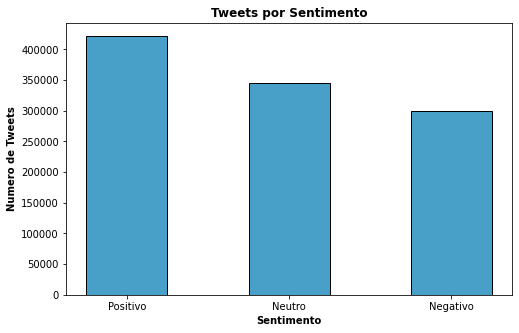

In [170]:
# Graphing the number of  tweets by sentiment
data_t = {'Positivo':bolsonaro_positive,'Neutro':bolsonaro_neutral,'Negativo':bolsonaro_negative}
sentiment_t = data_t.keys()
num_tweets_t = data_t.values() 

plt.figure(figsize = (8, 5)) 

plt.bar(sentiment_t, num_tweets_t, color ='#48A0C9', width = 0.5, edgecolor='black',) 

plt.xlabel("Sentimento", fontweight ='bold') 
plt.ylabel("Numero de Tweets", fontweight ='bold') 
plt.title("Tweets por Sentimento", fontweight ='bold') 
plt.show() 

In [171]:
# Function to return a string of all words in all tweets

def get_all_tweets(df,by_sentiment=False,sentiment="positivo"):
    
    # Combine all words in tweets into a string
    if by_sentiment:
        if sentiment == "positivo":
            words = ' '.join((df.loc[df['predict']=='positivo'])['Tweet_Text'].apply(lambda x: ' '.join(x)))
        elif sentiment == "neutro":
            words = ' '.join((df.loc[df['predict']=='neutro'])['Tweet_Text'].apply(lambda x: ' '.join(x)))
        else:
            words = ' '.join((df.loc[df['predict']=='negativo'])['Tweet_Text'].apply(lambda x: ' '.join(x)))
    else:
        words = ' '.join(df['Tweet_Text'].apply(lambda x: ' '.join(x)))
        
    return words

In [726]:
# Create word strings
words = get_all_tweets(df_b)
words_pos = get_all_tweets(df_b,True,"positivo")
words_neu = get_all_tweets(df_b,True,"neutro")
words_neg= get_all_tweets(df_b,True,"negativo")



In [173]:
#funcao retorna tokens palavras
def stringToList(string):
    listRes = list(string.split(" "))
    return listRes

In [174]:
tokens = stringToList(words)
tokens_pos = stringToList(words_pos)
tokens_neu = stringToList(words_neu)
tokens_neg = stringToList(words_neg)    

In [746]:
print(pd.DataFrame(FreqDist(tokens_neg).most_common(10), columns = ["Palavra","Frequência"]))

      Palavra  Frequência
0   bolsonaro      320864
1        lula       53820
2  democracia       34064
3     governo       26852
4      brasil       25184
5       fazer       25003
6      cadeia       24220
7       ficar       22256
8        todo       20338
9         sai       20013


In [718]:
# Function to plot most frquent words
def plot_word_freq(tokens,sentiment,name,color):
    fdist = FreqDist(tokens)
    fdist_df = pd.DataFrame(fdist.most_common(10), columns = ["Palavra","Frequência"])
    fig = px.bar(fdist_df, x="Palavra", y="Frequência",
                 title="<b>Palavras mais frequentes em </b>" + "<b>Tweets</b>" + " " + sentiment + " " + name )
    fig.update_traces(marker=dict(color=color),selector=dict(type="bar"),
                      marker_line_color='black', marker_line_width=1.5, opacity=0.6)
    fig.show()


In [733]:
plot_word_freq(tokens,"<b>Total</b>","<b>Bolsonaro</b>","red")

In [734]:
plot_word_freq(tokens_pos,"<b>Positivos</b>","<b>Bolsonaro</b>","red")

In [721]:
plot_word_freq(tokens_neg,"<b>Negativos</b>","<b>Bolsonaro</b>","red")

In [732]:
plot_word_freq(tokens_neu,"<b>Neutros</b>","<b>Bolsonaro</b>","red")

In [727]:
# Function to generate word cloud
def create_wordcloud(words):
    
    # create wordcloud
    wordcloud = WordCloud(max_font_size=256, max_words=200, 
                          background_color="white",
                          collocations=False, 
                          width=2000, height=1000).generate(words)

    # display the generated image
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

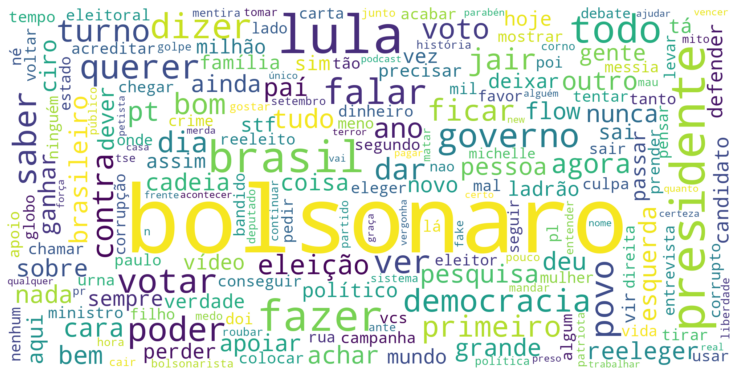

In [728]:
create_wordcloud(words)

In [122]:
#values= df_b.groupby(['User_city', 'predict'])['predict'].count()

In [55]:
#Separar valores data

def encode_dates(df, column):
    df = df.copy()
    df[column] = pd.to_datetime(df[column], format='%Y-%m-%d')
    df[column + '_year'] = df[column].apply(lambda x: x.year)
    df[column + '_month'] = df[column].apply(lambda x: x.month)
    df[column + '_day'] = df[column].apply(lambda x: x.day)
    df = df.drop(column, axis=1)
    return df


In [56]:
df_b= encode_dates(df_b, column='Date_Created')

In [57]:
df_b['User_state']= df_b['User_Location'].str.split(',',n=1, expand=True)[1]

In [58]:
df_b['User_city']= df_b['User_Location'].str.split(',',n=1, expand=True)[0]

In [107]:
df_b.head()

,Tweet_ID,Tweet_Text,Created_at,Tweet_Geo,User_Name,User_Location,Time_Created,Text_Final,predict,Date_Created_year,Date_Created_month,Date_Created_day,User_state,User_city
0,1558402223272517632,"[lula, bolsonaro, coisa, corrupto, incompetent...",2022-08-13 07:36:58-03:00,NaN,Arthur J. F. Braga,NaN,07:36:58,"['lula', 'bolsonaro', 'coisa', 'corrupto', 'in...",positivo,2022,8,13,NaN,NaN
1,1558402221531959296,"[bolsonaro, manifestar, sobre, fake, news, alm...",2022-08-13 07:36:57-03:00,NaN,Jacinto Sorato (Zorat),"Santa Fé do Sul, Brasil",07:36:57,"['bolsonaro', 'manifestar', 'sobre', 'fake', '...",negativo,2022,8,13,Brasil,Santa Fé do Sul
2,1558402219875115008,"[jornalista, dar, notícia, dizer, bolsonaro, r...",2022-08-13 07:36:57-03:00,NaN,Cristina Oliveira,Florianópolis,07:36:57,"['jornalista', 'dar', 'notícia', 'dizer', 'bol...",positivo,2022,8,13,None,Florianópolis
3,1558402198731689991,"[acreditar, fake, news, bolsonaro, esposa, alm...",2022-08-13 07:36:52-03:00,NaN,camila,NaN,07:36:52,"['acreditar', 'fake', 'news', 'bolsonaro', 'es...",positivo,2022,8,13,NaN,NaN
4,1558402180436172800,"[bom, bolsonaro, lula, porquê]",2022-08-13 07:36:48-03:00,NaN,Akemi,NaN,07:36:48,"['bom', 'bolsonaro', 'lula', 'porquê']",negativo,2022,8,13,NaN,NaN


In [185]:
Tweets_d= df_b.groupby([df_b['Created_at'].dt.strftime('%m-%d'), 'predict'])['Tweet_ID'].count().reset_index()

In [738]:
Tweets_l.to_csv ('Analise Temporal Bolsonaro.csv')

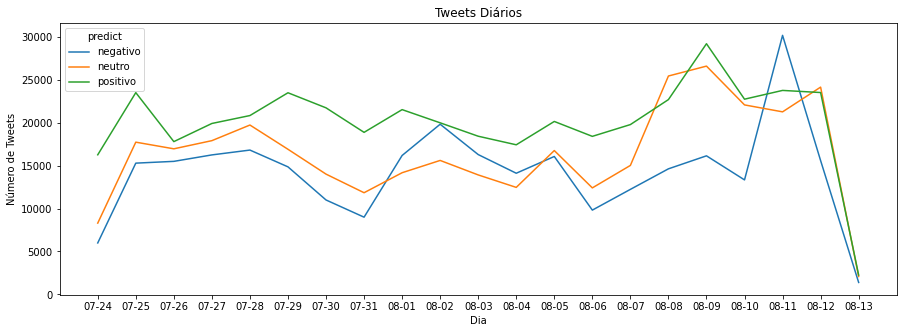

In [186]:
plt.figure(figsize=(15,5))
plot1= sns.lineplot(x = 'Created_at', y = 'Tweet_ID', hue='predict', data = Tweets_d)
plot1.set(xlabel='Dia', ylabel='Número de Tweets')
plot1. set_title('Tweets Diários Bolsonaro')
#plot1.set_yscale('log')
#plot1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000) + 'K'))

plt.show()


In [97]:
#Tweets_l= df_b.groupby(['User_state', 'predict']).count().reset_index()

In [188]:
#Read data Lula
#preprocess data
df_l= pd.read_csv("search_lula -is:retweet lang:pt.csv")

preprocess(df_l)

In [584]:
df_s.shape

(61381, 10)

In [499]:
Test_X_l = Tfidf_vect.transform(df_l['Text_Final'])

# Classificador SVM
# ajustar o conjunto de dados de treinamento no classificador SVM
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# prever os rótulos no conjunto de dados de validação
predictions_SVM = SVM.predict(Test_X_l )
predictions = SVM.predict(Test_X_l )
predictions_recovered = Encoder.inverse_transform(predictions)
df_l['predict'] = predictions_recovered 

print (df_l['predict'].value_counts())

neutro      614474
negativo    268890
positivo    146246
Name: predict, dtype: int64


In [197]:
# Overall sentiment breakdown

lula_positive = len(df_l.loc[df_l['predict']=='positivo'])
lula_neutral = len(df_l.loc[df_l['predict']=='neutro'])
lula_negative = len(df_l.loc[df_l['predict']=='negativo'])

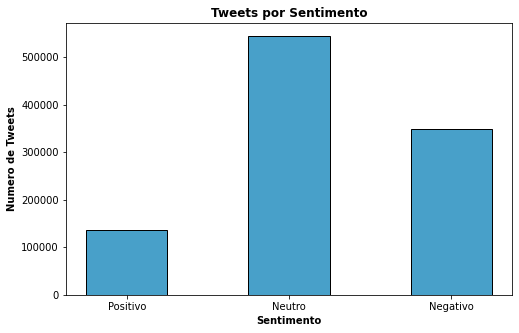

In [198]:
# Graphing the number of  tweets by sentiment
data_t = {'Positivo':lula_positive,'Neutro':lula_neutral,'Negativo':lula_negative}
sentiment_t = data_t.keys()
num_tweets_t = data_t.values() 

plt.figure(figsize = (8, 5)) 

plt.bar(sentiment_t, num_tweets_t, color ='#48A0C9', width = 0.5, edgecolor='black',) 

plt.xlabel("Sentimento", fontweight ='bold') 
plt.ylabel("Numero de Tweets", fontweight ='bold') 
plt.title("Tweets por Sentimento", fontweight ='bold') 
plt.show() 

In [201]:
# Create word strings
words_l = get_all_tweets(df_l)
words_pos_l = get_all_tweets(df_l,True,"positivo")
words_neu_l = get_all_tweets(df_l,True,"neutro")
words_neg_l= get_all_tweets(df_l,True,"negativo")

In [202]:
tokens_l = stringToList(words_l)
tokens_pos_l = stringToList(words_pos_l)
tokens_neu_l = stringToList(words_neu_l)
tokens_neg_l = stringToList(words_neg_l)   

In [749]:
print(pd.DataFrame(FreqDist(tokens_neg_l).most_common(10), columns = ["Palavra","Frequência"]))

      Palavra  Frequência
0        lula      377415
1   bolsonaro       65774
2      brasil       37617
3       fazer       34729
4        todo       28423
5        povo       26142
6     governo       24116
7       poder       23199
8      querer       23173
9  presidente       21393


In [205]:
plot_word_freq(tokens_l,"<b>Total</b>","<b>Lula</b>","red")

In [748]:
plot_word_freq(tokens_pos_l,"<b>Positivos</b>","<b>Lula</b>","red")

In [207]:
plot_word_freq(tokens_neg_l,"<b>Negativos</b>","<b>Lula</b>","red")

In [208]:
plot_word_freq(tokens_neu_l,"<b>Neutros</b>","<b>Lula</b>","red")

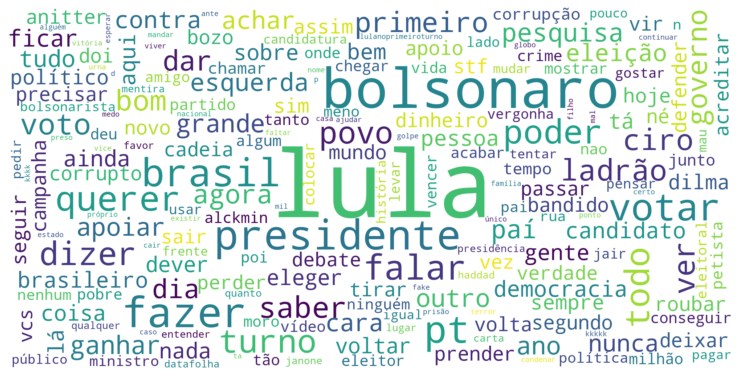

In [743]:
create_wordcloud(words_l)

In [210]:
Tweets_l= df_l.groupby([df_l['Created_at'].dt.strftime('%m-%d'), 'predict'])['Tweet_ID'].count().reset_index()

In [739]:
Tweets_l.to_csv ('Analise Temporal lula.csv')

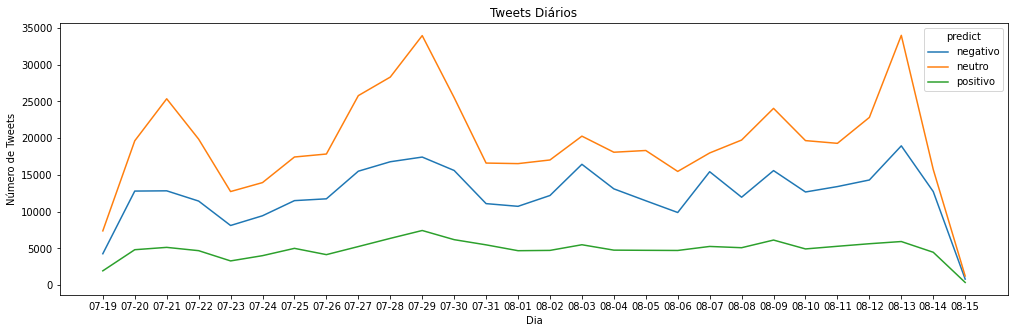

In [241]:
plt.figure(figsize=(17,5))
plot1= sns.lineplot(x = 'Created_at', y = 'Tweet_ID', hue='predict', data = Tweets_l)
plot1.set(xlabel='Dia', ylabel='Número de Tweets')
plot1. set_title('Tweets Diários')
#plot1.set_yscale('log')
#plot1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000) + 'K'))

plt.show()

In [212]:
#Read data Ciro
#preprocess data
df_c= pd.read_csv("search_ciro -is:retweet lang:pt.csv")

preprocess(df_c)

In [244]:
df_c.tail()

,Tweet_ID,Tweet_Text,Created_at,Tweet_Geo,User_Name,User_Location,Date_Created,Time_Created,Text_Final,predict
1097893,1513878115784830986,"[ambos, importante, ciro, caminho, certo, inte...",2022-04-12 10:54:03-03:00,NaN,Ney Monte 🌹,"Martinópole, Brasil",2022-04-12,10:54:03,"['ambos', 'importante', 'ciro', 'caminho', 'ce...",neutro
1097894,1513878061946744838,"[votar, alckmin, geddel, to, prostituição, pol...",2022-04-12 10:53:51-03:00,NaN,Alex É 1️⃣2️⃣🇧🇷 - GOD'S NOT DEAD,NaN,2022-04-12,10:53:51,"['votar', 'alckmin', 'geddel', 'to', 'prostitu...",neutro
1097895,1513877985786531851,"[ciro, gomes, razão, agoraéciro]",2022-04-12 10:53:32-03:00,NaN,Futuro PND✊ Ciro Gomes 🌹 O Dever da Esperança💚,NaN,2022-04-12,10:53:32,"['ciro', 'gomes', 'razão', 'agoraéciro']",neutro
1097896,1513877967214104595,"[nao, eh, questão, incômodo, posição, definido...",2022-04-12 10:53:28-03:00,NaN,Leitor de comentários,NaN,2022-04-12,10:53:28,"['nao', 'eh', 'questão', 'incômodo', 'posição'...",neutro
1097897,1513877880614305792,"[evitem, oportunidade, fazer, país, fazer, ago...",2022-04-12 10:53:07-03:00,NaN,Marcus Ciro 12🌹,"Ceará, Brasil",2022-04-12,10:53:07,"['evitem', 'oportunidade', 'fazer', 'país', 'f...",neutro


In [215]:
Test_X_c = Tfidf_vect.transform(df_c['Text_Final'])

# ajustar o conjunto de dados de treinamento no classificador NB
# Naive = naive_bayes.MultinomialNB()
# Naive.fit(Train_X_Tfidf,Train_Y)
# # prever os rótulos no conjunto de dados de validação
# predictions_NB = Naive.predict(Test_X_Tfidf)
# predictions_NBTest = Naive.predict(Test_X_B)
# Test_YRecover = Encoder.inverse_transform(predictions_NBTest)
# #print(Test_YRecover)

# Classificador SVM
# ajustar o conjunto de dados de treinamento no classificador SVM
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# prever os rótulos no conjunto de dados de validação
predictions_SVM = SVM.predict(Test_X_c )
predictions = SVM.predict(Test_X_c )
predictions_recovered = Encoder.inverse_transform(predictions)
df_c['predict'] = predictions_recovered 

print (df_c['predict'].value_counts())

neutro      693411
negativo    271467
positivo    133020
Name: predict, dtype: int64


In [216]:
# Overall sentiment breakdown

ciro_positive = len(df_c.loc[df_c['predict']=='positivo'])
ciro_neutral = len(df_c.loc[df_c['predict']=='neutro'])
ciro_negative = len(df_c.loc[df_c['predict']=='negativo'])

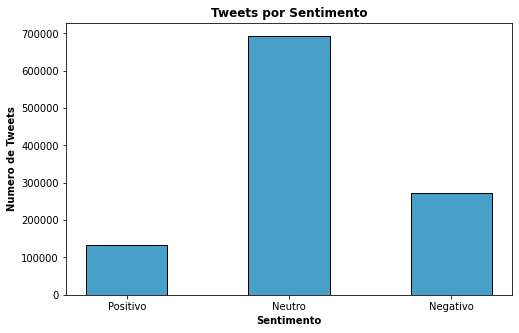

In [217]:
# Graphing the number of  tweets by sentiment
data_t = {'Positivo':ciro_positive,'Neutro':ciro_neutral,'Negativo':ciro_negative}
sentiment_t = data_t.keys()
num_tweets_t = data_t.values() 

plt.figure(figsize = (8, 5)) 

plt.bar(sentiment_t, num_tweets_t, color ='#48A0C9', width = 0.5, edgecolor='black',) 

plt.xlabel("Sentimento", fontweight ='bold') 
plt.ylabel("Numero de Tweets", fontweight ='bold') 
plt.title("Tweets por Sentimento", fontweight ='bold') 
plt.show() 

In [220]:
# Create word strings
words_c = get_all_tweets(df_c)
words_pos_c = get_all_tweets(df_c,True,"positivo")
words_neu_c = get_all_tweets(df_c,True,"neutro")
words_neg_c= get_all_tweets(df_c,True,"negativo")

In [221]:
tokens_c = stringToList(words_c)
tokens_pos_c = stringToList(words_pos_c)
tokens_neu_c = stringToList(words_neu_c)
tokens_neg_c = stringToList(words_neg_c)  

In [751]:
print(pd.DataFrame(FreqDist(tokens_neg_c).most_common(10), columns = ["Palavra","Frequência"]))

     Palavra  Frequência
0       ciro      254269
1       lula       65947
2      fazer       32876
3  bolsonaro       32294
4       todo       27962
5     brasil       25310
6      turno       23731
7       voto       23709
8      votar       21601
9      poder       19976


In [222]:
plot_word_freq(tokens_c,"<b>Total</b>","<b>Ciro</b>","red")

In [223]:
plot_word_freq(tokens_pos_c,"<b>Positivos</b>","<b>Ciro</b>","red")

In [753]:
plot_word_freq(tokens_neg_c,"<b>Negativos</b>","<b>Ciro</b>","red")

In [225]:
plot_word_freq(tokens_neg_c,"<b>Neutros</b>","<b>Ciro</b>","red")

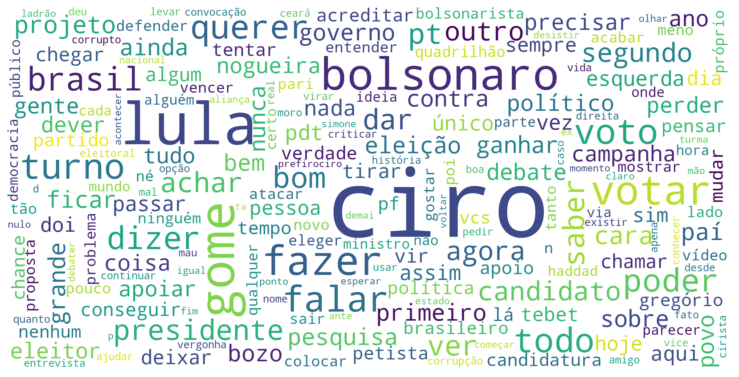

In [744]:
create_wordcloud(words_c)

In [227]:
Tweets_c= df_c.groupby([df_c['Created_at'].dt.strftime('%m-%d'), 'predict'])['Tweet_ID'].count().reset_index()

In [740]:
Tweets_c.to_csv ('Analise Temporal ciro.csv')

In [741]:
Tweets_c.head()

,Created_at,predict,Tweet_ID
0,04-12,negativo,1285
1,04-12,neutro,2579
2,04-12,positivo,578
3,04-13,negativo,2164
4,04-13,neutro,4272


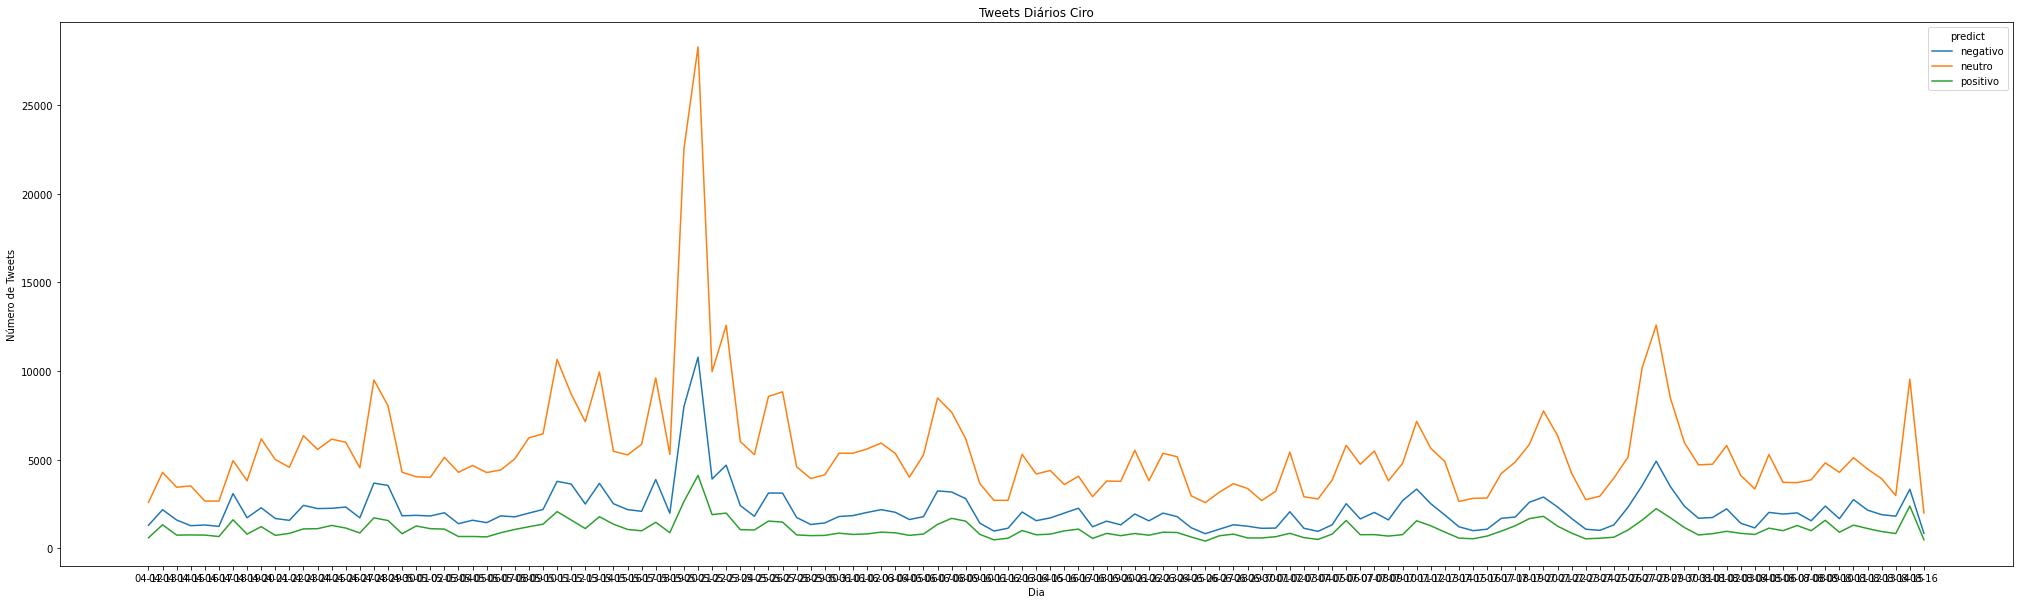

In [240]:
plt.figure(figsize=(33,10))
plot1= sns.lineplot(x = 'Created_at', y = 'Tweet_ID', hue='predict', data = Tweets_c)
plot1.set(xlabel='Dia', ylabel='Número de Tweets')
plot1. set_title('Tweets Diários Ciro')
plot1.set_yscale('log')
#plot1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000) + 'K'))

plt.show()

In [245]:
#Read data Simone Tebet
#preprocess data
df_s= pd.read_csv("search_simone tebet -is:retweet lang:pt.csv")

preprocess(df_s)

In [277]:
df_s.drop(df_s.tail(2).index,inplace=True) # drop last n rows

In [278]:
df_s.tail()

,Tweet_ID,Tweet_Text,Created_at,Tweet_Geo,User_Name,User_Location,Date_Created,Time_Created,Text_Final,predict
61378,1477265243613147136,"[nivel, baixo, ciro, simone, tebet]",2022-01-01 10:07:34-03:00,NaN,JJ Silva,NaN,2022-01-01,10:07:34,"['nivel', 'baixo', 'ciro', 'simone', 'tebet']",negativo
61379,1477234235119394816,"[perde, simone, tebet, primeiro, turno]",2022-01-01 08:04:21-03:00,NaN,LAP,NaN,2022-01-01,08:04:21,"['perde', 'simone', 'tebet', 'primeiro', 'turno']",negativo
61380,1477224154164346886,"[político, desviar, recurso, covid, dever, inv...",2022-01-01 07:24:18-03:00,NaN,Julio Sant'anna,NaN,2022-01-01,07:24:18,"['político', 'desviar', 'recurso', 'covid', 'd...",neutro
61381,1477150528333361154,"[maravilhoso, caio, coppolla, destruiu, simone...",2022-01-01 02:31:44-03:00,NaN,Carolina,Brasil,2022-01-01,02:31:44,"['maravilhoso', 'caio', 'coppolla', 'destruiu'...",negativo
61382,1477122036006887424,"[frase, ano, ninguém, imaginar, poder, namorar...",2022-01-01 00:38:31-03:00,NaN,Gustavo Fernandes,Porto Alegre,2022-01-01,00:38:31,"['frase', 'ano', 'ninguém', 'imaginar', 'poder...",negativo


In [279]:
Test_X_s = Tfidf_vect.transform(df_s['Text_Final'])

# ajustar o conjunto de dados de treinamento no classificador NB
# Naive = naive_bayes.MultinomialNB()
# Naive.fit(Train_X_Tfidf,Train_Y)
# # prever os rótulos no conjunto de dados de validação
# predictions_NB = Naive.predict(Test_X_Tfidf)
# predictions_NBTest = Naive.predict(Test_X_B)
# Test_YRecover = Encoder.inverse_transform(predictions_NBTest)
# #print(Test_YRecover)

# Classificador SVM
# ajustar o conjunto de dados de treinamento no classificador SVM
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# prever os rótulos no conjunto de dados de validação
predictions_SVM = SVM.predict(Test_X_s )
predictions = SVM.predict(Test_X_s )
predictions_recovered = Encoder.inverse_transform(predictions)
df_s['predict'] = predictions_recovered 

print (df_s['predict'].value_counts())

neutro      27004
negativo    26599
positivo     7778
Name: predict, dtype: int64


In [280]:
# Overall sentiment breakdown

simone_positive = len(df_s.loc[df_s['predict']=='positivo'])
simone_neutral = len(df_s.loc[df_s['predict']=='neutro'])
simone_negative = len(df_s.loc[df_s['predict']=='negativo'])

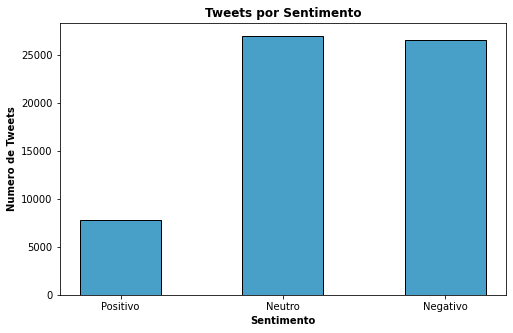

In [281]:
# Graphing the number of  tweets by sentiment
data_t = {'Positivo':simone_positive,'Neutro':simone_neutral,'Negativo':simone_negative}
sentiment_t = data_t.keys()
num_tweets_t = data_t.values() 

plt.figure(figsize = (8, 5)) 

plt.bar(sentiment_t, num_tweets_t, color ='#48A0C9', width = 0.5, edgecolor='black',) 

plt.xlabel("Sentimento", fontweight ='bold') 
plt.ylabel("Numero de Tweets", fontweight ='bold') 
plt.title("Tweets por Sentimento", fontweight ='bold') 
plt.show() 

In [282]:
# Create word strings
words_s = get_all_tweets(df_s)
words_pos_s = get_all_tweets(df_s,True,"positivo")
words_neu_s = get_all_tweets(df_s,True,"neutro")
words_neg_s= get_all_tweets(df_s,True,"negativo")

In [283]:
tokens_s = stringToList(words_s)
tokens_pos_s = stringToList(words_pos_s)
tokens_neu_s = stringToList(words_neu_s)
tokens_neg_s = stringToList(words_neg_s)

In [756]:
print(pd.DataFrame(FreqDist(tokens_neg_s).most_common(10), columns = ["Palavra","Frequência"]))

     Palavra  Frequência
0      tebet       26913
1     simone       26792
2       lula        3898
3        mdb        2716
4  bolsonaro        2497
5     brasil        2105
6      votar        1995
7     mulher        1946
8       voto        1921
9       moro        1835


In [284]:
plot_word_freq(tokens_s,"<b>Total</b>","<b>Simone Tebet</b>","red")

In [758]:
plot_word_freq(tokens_pos_s,"<b>Positivos</b>","<b>Simone Tebet</b>","red")

In [286]:
plot_word_freq(tokens_neu_s,"<b>Negativos</b>","<b>Simone Tebet</b>","red")

In [287]:
plot_word_freq(tokens_neg_s,"<b>Neutros</b>","<b>Simone Tebet</b>","red")

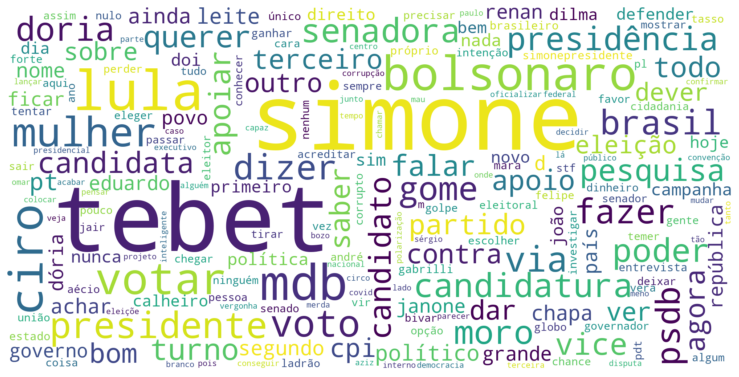

In [745]:
create_wordcloud(words_s)

In [291]:
Tweets_s= df_s.groupby([df_s['Created_at'].dt.strftime('%m-%d'), 'predict'])['Tweet_ID'].count().reset_index()

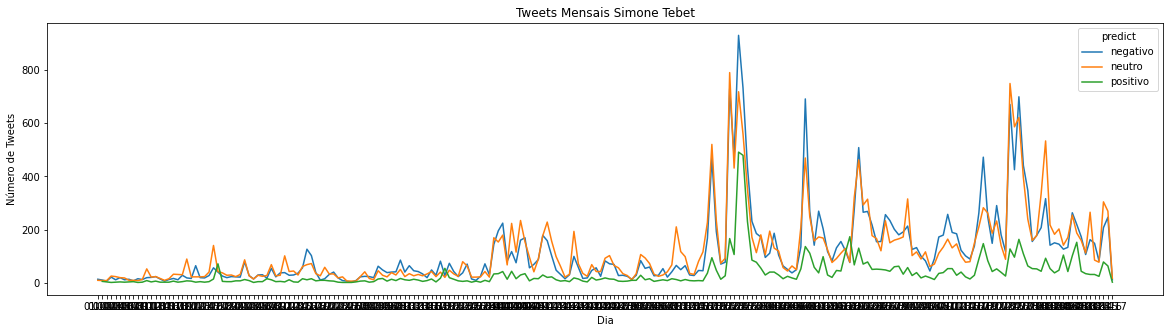

In [292]:
plt.figure(figsize=(20,5))
plot1= sns.lineplot(x = 'Created_at', y = 'Tweet_ID', hue='predict', data = Tweets_s)
plot1.set(xlabel='Dia', ylabel='Número de Tweets')
plot1. set_title('Tweets Mensais Simone Tebet')
#plot1.set_yscale('log')
#plot1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000) + 'K'))

plt.show()

In [300]:
#dados_anotados_simone = pd.read_csv("search_simone tebet -is:retweet lang:pt.csv").sample(n = 500)

In [301]:
#dados_anotados_simone.to_csv('dados_anotados_simone.csv')

In [742]:
Tweets_s.to_csv ('Analise Temporal simone.csv')